In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch

import copy
import random

from ECGDataset import ECGDataset

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
window_size = 180
train_ds= ECGDataset(f"data/mit_bih_train_{window_size}.csv", f"data/beat_type_train_{window_size}.csv")
test_ds = ECGDataset(f"data/mit_bih_test_{window_size}.csv", f"data/beat_type_test_{window_size}.csv")
val_ds = ECGDataset(f"data/mit_bih_val_{window_size}.csv", f"data/beat_type_val_{window_size}.csv")


In [16]:
train_ds.y

[['N'],
 ['V'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['R'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['/'],
 ['N'],
 ['/'],
 ['N'],
 ['N'],
 ['V'],
 ['N'],
 ['N'],
 ['R'],
 ['/'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['L'],
 ['N'],
 ['N'],
 ['R'],
 ['N'],
 ['N'],
 ['N'],
 ['/'],
 ['N'],
 ['L'],
 ['N'],
 ['f'],
 ['N'],
 ['N'],
 ['L'],
 ['N'],
 ['N'],
 ['V'],
 ['A'],
 ['N'],
 ['L'],
 ['0 or more than 1 annotation'],
 ['V'],
 ['/'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['V'],
 ['N'],
 ['/'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['V'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['A'],
 ['N'],
 ['V'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['/'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['L'],
 ['N'],
 ['N'],
 ['N'],
 ['N'],
 ['R'],
 ['N'],
 ['0 or more than 1 annotation'],
 ['N

['N']

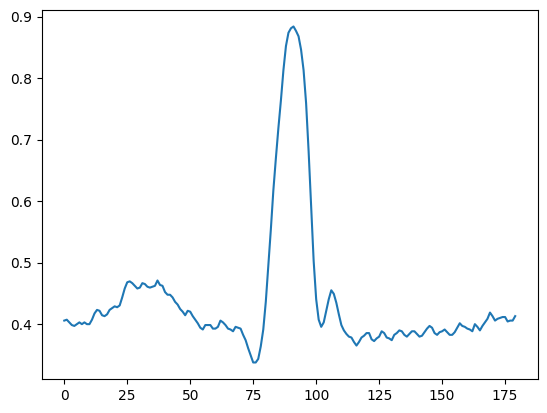

In [17]:
plt.plot(train_ds.df[0])
train_ds.y[0]

In [18]:
def train_model(model, train_dataset, val_dataset, n_epochs, lr, batch_size):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = torch.nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    val_losses = []

    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dl = torch.utils.data.DataLoader(val_dataset)

    size = len(train_dl.dataset)
    for batch, (X,y) in enumerate(train_dl):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X).unsqueeze(0)
        loss = criterion(pred, X)
        train_losses.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for seq_true in val_dl:
        seq_true = seq_true.to(device)   # putting sequence to gpu
        seq_pred = model(seq_true).unsqueeze(0)    # prediction

        loss = criterion(seq_pred, seq_true)  # recording loss

        val_losses.append(loss.item())    # storing loss into the validation losses

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history

In [19]:
from lstmae import RecurrentAutoencoder

model = RecurrentAutoencoder(180, 1, device, 64)
model = model.to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [20]:
model, history = train_model(
  model, 
  train_dataset=train_ds, 
  val_dataset=val_ds,
  n_epochs=10,
  lr=5e-4,
  batch_size=1
)

loss: 78.582321  [    1/77720]
loss: 8.421872  [10001/77720]
loss: 12.556128  [20001/77720]
loss: 5.678539  [30001/77720]


KeyboardInterrupt: 

In [21]:
plt.plot(history["train"])
plt.plot(history["val"])

NameError: name 'history' is not defined

In [28]:
torch.save(model.state_dict(), "models/lstmae_5000.pth")

In [9]:
model = torch.load("models/lstmae_5000", map_location=torch.device('cpu'))

In [31]:
model = model.to(device="cpu")

In [7]:
train_ds.__getitem__(0)

(tensor([[0.4058],
         [0.4072],
         [0.4029],
         [0.3986],
         [0.3971],
         [0.4000],
         [0.4029],
         [0.4000],
         [0.4029],
         [0.4000],
         [0.4000],
         [0.4072],
         [0.4174],
         [0.4232],
         [0.4217],
         [0.4145],
         [0.4130],
         [0.4159],
         [0.4232],
         [0.4261],
         [0.4290],
         [0.4275],
         [0.4304],
         [0.4435],
         [0.4580],
         [0.4681],
         [0.4696],
         [0.4667],
         [0.4623],
         [0.4580],
         [0.4594],
         [0.4667],
         [0.4652],
         [0.4609],
         [0.4594],
         [0.4609],
         [0.4623],
         [0.4710],
         [0.4638],
         [0.4623],
         [0.4522],
         [0.4478],
         [0.4478],
         [0.4435],
         [0.4362],
         [0.4319],
         [0.4246],
         [0.4203],
         [0.4145],
         [0.4217],
         [0.4203],
         [0.4130],
         [0.

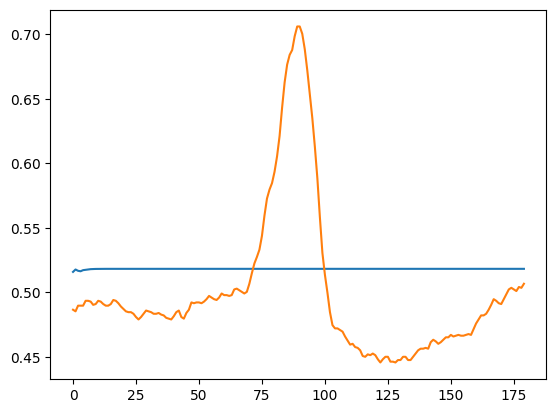

In [22]:
plt.plot(model(test_ds.__getitem__(123)[0]).cpu().detach().numpy().squeeze())
plt.plot(test_ds.__getitem__(123)[0].cpu().detach().numpy().squeeze())